# Preprocessing

In [1]:
import numpy as np 
import pandas as pd
from pandas import datetime
import pandas_datareader.data as web

startDate = datetime(2010,1,4)
endDate = datetime(2020,4,1)
#Import data for Microsoft Stocks
data = web.DataReader('MSFT', 'yahoo', startDate, endDate)
data = data.reset_index()
data.head(10)
data['Date'] = data['Date'].astype(str)
data.dtypes


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  import sys


Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

Create a dataframe with a variable size sliding window

In [2]:
dif = data['Close'] - data['Open']
dif_data = pd.DataFrame([data['Date'], dif]).T

n = 7 #Window Size
window = []

#Create a dataframe with a rolling window of size n
for r in range(n,len(dif_data.index)):
  frame = [dif_data.iloc[r]['Date'], dif_data.iloc[r]['Unnamed 0']]
  for w in range(1,n+1):
    frame.append(dif_data.iloc[r-w]['Unnamed 0'])
  window.append(frame)
windowed_data = pd.DataFrame(window)

display(windowed_data)

,0,1,2,3,4,5,6,7,8
0,2010-01-13,0.090000,-0.080000,-0.439999,0.379999,-0.179998,-0.109999,0.109999,0.330000
1,2010-01-14,0.650000,0.090000,-0.080000,-0.439999,0.379999,-0.179998,-0.109999,0.109999
2,2010-01-15,-0.219999,0.650000,0.090000,-0.080000,-0.439999,0.379999,-0.179998,-0.109999
3,2010-01-19,0.350000,-0.219999,0.650000,0.090000,-0.080000,-0.439999,0.379999,-0.179998
4,2010-01-20,-0.219999,0.350000,-0.219999,0.650000,0.090000,-0.080000,-0.439999,0.379999
...,...,...,...,...,...,...,...,...,...
2567,2020-03-26,7.710007,-1.990005,4.589996,-1.029999,-8.649994,-0.059998,2.399994,6.570007
2568,2020-03-27,-2.050003,7.710007,-1.990005,4.589996,-1.029999,-8.649994,-0.059998,2.399994
2569,2020-03-30,7.789993,-2.050003,7.710007,-1.990005,4.589996,-1.029999,-8.649994,-0.059998
2570,2020-03-31,-1.689987,7.789993,-2.050003,7.710007,-1.990005,4.589996,-1.029999,-8.649994


In [3]:
#Convert the data to binary values, where True is an increase in value and False is a decrease in value
binary_window = windowed_data[0]
win = windowed_data.drop(columns=0)
binary_window = pd.concat([binary_window,win.mask(win > 0, True).mask(win < 0, False)], axis=1)
display(binary_window)

,0,1,2,3,4,5,6,7,8
0,2010-01-13,True,False,False,True,False,False,True,True
1,2010-01-14,True,True,False,False,True,False,False,True
2,2010-01-15,False,True,True,False,False,True,False,False
3,2010-01-19,True,False,True,True,False,False,True,False
4,2010-01-20,False,True,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...
2567,2020-03-26,True,False,True,False,False,False,True,True
2568,2020-03-27,False,True,False,True,False,False,False,True
2569,2020-03-30,True,False,True,False,True,False,False,False
2570,2020-03-31,False,True,False,True,False,True,False,False


2      3      4      5      6      7      8    
False  False  False  False  False  False  False     7
                                          True     11
                                   True   False    11
                                          True      9
                            True   False  False    11
                                                   ..
True   True   True   True   False  True   True      8
                            True   False  False    14
                                          True     10
                                   True   False    13
                                          True     12
Length: 128, dtype: int64

20
4


2      3      4      5      6      7      8    
False  False  False  False  False  False  False     6
                                          True      7
                                   True   False     6
                                          True     12
                            True   False  False     9
                                                   ..
True   True   True   True   False  True   True     14
                            True   False  False     8
                                          True      5
                                   True   False    11
                                          True     13
Length: 128, dtype: int64

18
4


0     1
2     3     4     5     6     7     8              
False False False False False False False   7  True
                                    True   11  True
                              True  False  11  True
                                    True    9  True
                        True  False False  11  True
...                                        ..   ...
True  True  True  True  False True  True    8  True
                        True  False False  14  True
                                    True   10  True
                              True  False  13  True
                                    True   12  True

[128 rows x 2 columns]

0      1
2     3     4     5     6     7     8               
False False False False False False False   6  False
                                    True    7  False
                              True  False   6  False
                                    True   12  False
                        True  False False   9  False
...                                        ..    ...
True  True  True  True  False True  True   14  False
                        True  False False   8  False
                                    True    5  False
                              True  False  11  False
                                    True   13  False

[128 rows x 2 columns]

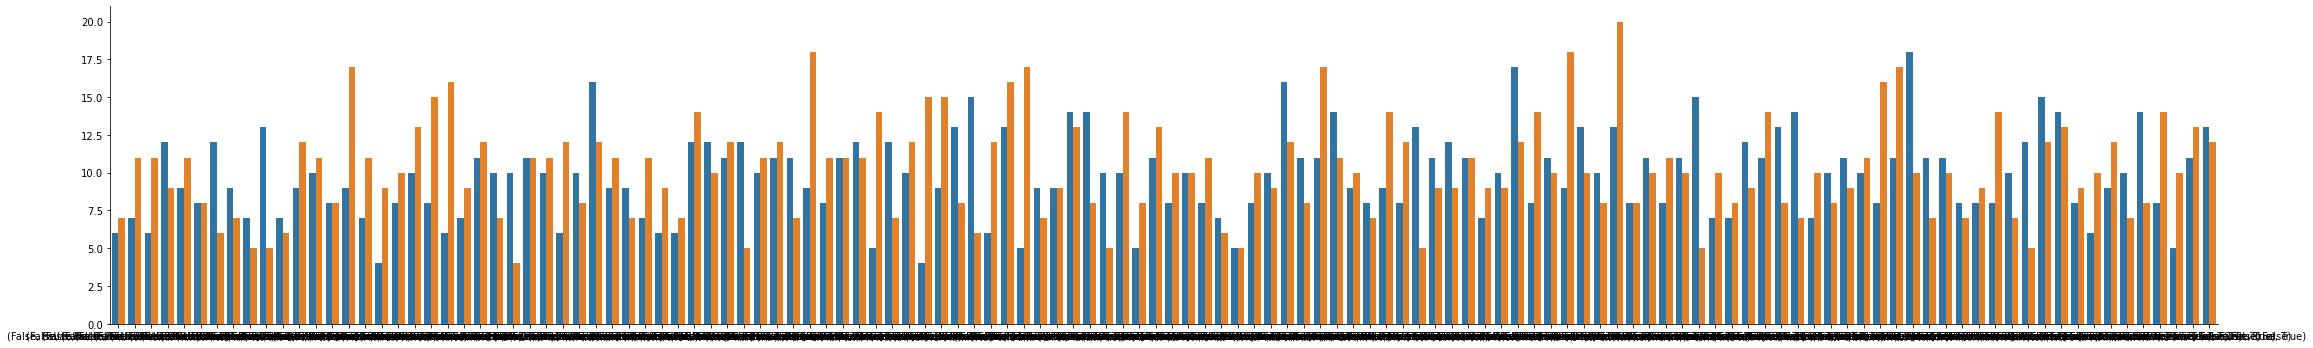

In [7]:
# This section groups windows by their combination of truth values, creates 256
# unique combinations with a window size of 7. This shouldn't be run with higher
# window sizes for performance reasons.

bin_win = binary_window.drop(columns=[0])
bin_win_true = bin_win[bin_win[1] == True].drop(columns=1)
bin_win_true = bin_win_true.groupby(bin_win_true.columns.tolist(),as_index=False).size()
bin_win_false = bin_win[bin_win[1] == False].drop(columns=1)
bin_win_false = bin_win_false.groupby(bin_win_false.columns.tolist(),as_index=False).size()

display(bin_win_true)
print(bin_win_true.max())
print(bin_win_true.min())
display(bin_win_false)
print(bin_win_false.max())
print(bin_win_false.min())

bin_win_true = pd.concat([bin_win_true,bin_win_true >= 0],axis=1)
bin_win_false = pd.concat([bin_win_false, bin_win_false < 0],axis=1)

display(bin_win_true)
display(bin_win_false)

chart = pd.concat([bin_win_true,bin_win_false],axis=0)

import seaborn
#Seaborn has an issue with data a boolean array; try block just hides exception messages
try:
  fg = seaborn.catplot(x=chart.index, y=0, hue=1, 
                        data=chart, kind='bar', height=5, aspect=6)
except:
  print("")

# Processing

Naive Bayes implementations to try: Gaussian and Bernouli (binary)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB

y = windowed_data[1] > 0
X = windowed_data.drop(columns=[0,1])

#Split is determined randomly each time this block is run; rerun to see various 50/50 splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

Xb_train = X_train > 0
Xb_test = X_test > 0

gnb = GaussianNB()
bnb = BernoulliNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Gaussian: Number of mislabeled points out of a total %d points : %d"
       % (X_test.shape[0], (y_test != y_pred).sum()))
print("Accuracy: ", (y_test == y_pred).sum()/X_test.shape[0])
yb_pred = bnb.fit(Xb_train, y_train).predict(Xb_test)
print("Bernoulli: Number of mislabeled points out of a total %d points : %d"
       % (Xb_test.shape[0], (y_test != yb_pred).sum()))
print("Accuracy: ", (y_test == yb_pred).sum()/Xb_test.shape[0])

Gaussian: Number of mislabeled points out of a total 1286 points : 634
Accuracy:  0.5069984447900466
Bernoulli: Number of mislabeled points out of a total 1286 points : 683
Accuracy:  0.468895800933126
